In [35]:
import sys
import os

sys.path.append(os.path.abspath('src')) 
from geo_tools import reverse_geocode_dataframe

In [36]:
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

In [ ]:
# les types de places qui m'ntéressent (source https://wiki.openstreetmap.org/wiki/Key:amenity)
tags = {
    "amenity": [
        # Nourriture + boissons
        "restaurant", "cafe", "pub", "bar", "ice_cream", "fast_food",
        
        # Services publics
        "post_office", "library", "townhall", "community_centre",
        
        # Santé
        "clinic", "hospital", "pharmacy", "doctors", "dentist",
        
        # Transport
        "bicycle_rental", "parking", "taxi", "bus_station", 
        
        # Commerces
        "fuel",
        
        # Éducation
        "school", "university", "college", "kindergarten",
        
        # Financier
        "bank", "atm",
        
        # Religion
        "place_of_worship"
    ]
}

gdf_pois = ox.features_from_place("Québec city, canada", tags=tags)

In [38]:
categories = {
    'Food': ['restaurant', 'cafe', 'pub', 'bar', 'ice_cream', 'fast_food'],
    'Health': ['clinic', 'hospital', 'pharmacy', 'doctors', 'dentist'],
    'Public Services': ['post_office', 'library', 'townhall', 'community_centre'],
    'Transport': ['bicycle_rental', 'parking', 'taxi', 'bus_station', 'fuel'],
    'Education': ['school', 'university', 'college', 'kindergarten'],
    'Financial': ['bank', 'atm'],
    'Religious': ['place_of_worship']
}

amenity_to_category = {amenity: cat for cat, amenities in categories.items() for amenity in amenities}
gdf_pois['Category'] = gdf_pois['amenity'].map(amenity_to_category)
gdf_pois = gdf_pois[['name', 'geometry', 'amenity', 'Category']]

In [39]:
gdf_pois.head()

name                    geometry      amenity   Category
element id                                                                                        
node    49474611   Caisse Populaire Desjardins   POINT (-71.26978 46.7792)         bank  Financial
        265847671     La Roulotte du Boulevard  POINT (-71.21603 46.85481)    fast_food       Food
        275074044                 Petro-Canada  POINT (-71.31924 46.91669)         fuel  Transport
        275074469                          EKO  POINT (-71.29489 46.84882)         fuel  Transport
        277487880             Place d'Youville  POINT (-71.21476 46.81267)  bus_station  Transport

<Axes: >

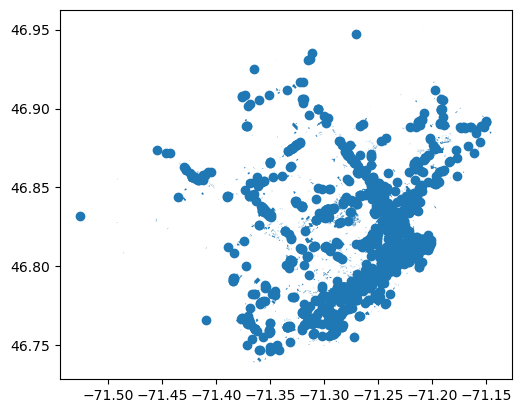

In [40]:
gdf_pois.plot()

In [41]:
gdf_pois.isna().sum()

name        3051
geometry       0
amenity        0
Category       0
dtype: int64

In [42]:
# 3051 lieux n'ont pas de nom, je vais utiliser le reverse geocoding pour combler les noms manquants avec l'api de geopy & google 
# Econnversion des Polygones/MultiPolygones en Points (centroïdes) nécessaires à l'API

In [43]:
print("Types de géométries présents")
print(gdf_pois.geom_type.unique())

print("\nRépartition par type")
print(gdf_pois.geom_type.value_counts())

Types de géométries présents
['Point' 'Polygon' 'MultiPolygon']

Répartition par type
Polygon         3394
Point           1497
MultiPolygon       3
Name: count, dtype: int64


In [ ]:
gdf_pois['geom_type'] = gdf_pois.geometry.type

crosstable = pd.crosstab(
    index=gdf_pois['amenity'],
    columns=gdf_pois['geom_type'],
    margins=True,              
    margins_name='Total'
)
crosstable

geom_type,MultiPolygon,Point,Polygon,Total
amenity,,,,
atm,0,32,0,32
bank,0,79,8,87
bar,0,39,2,41
bicycle_rental,0,164,0,164
bus_station,0,7,4,11
cafe,0,130,12,142
clinic,0,27,4,31
college,0,6,8,14
community_centre,0,27,33,60


In [49]:
# Projection vers NAD83 CSRS MTM zone 7 
gdf_mtm = gdf_pois.to_crs(epsg=2949)

# Calcul du centroïde de la géometrie
gdf_mtm['geometry'] = gdf_mtm.geometry.centroid

# Retour vers le système WGS84
gdf_final = gdf_mtm.to_crs(epsg=4326)

<Axes: >

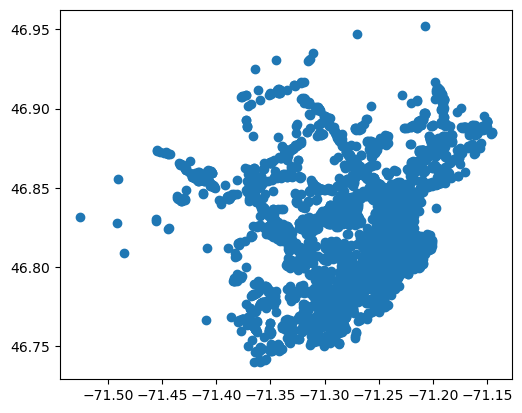

In [50]:
gdf_final.plot()

In [51]:
gdf_final.head()

name                    geometry      amenity   Category geom_type
element id                                                                                                  
node    49474611   Caisse Populaire Desjardins   POINT (-71.26978 46.7792)         bank  Financial     Point
        265847671     La Roulotte du Boulevard  POINT (-71.21603 46.85481)    fast_food       Food     Point
        275074044                 Petro-Canada  POINT (-71.31924 46.91669)         fuel  Transport     Point
        275074469                          EKO  POINT (-71.29489 46.84882)         fuel  Transport     Point
        277487880             Place d'Youville  POINT (-71.21476 46.81267)  bus_station  Transport     Point

In [ ]:
stats = gdf_final.groupby('amenity')['name'].agg(
    Total='size', 
    Missing_total = lambda x: x.isna().sum(),
    Pct_missing = lambda x: x.isna().mean() * 100
).reset_index()
stats

In [ ]:
df_final = reverse_geocode_dataframe(gdf_final, method='geopy')

--- Géocodage inverse via Google Maps API ---


100%|██████████| 4894/4894 [11:08<00:00,  7.32it/s]


In [ ]:
df_final['geopy_name'] = df_final['adresse_geopy'].str.split(',').str[0].str.strip()

In [ ]:
df_final.to_file("../output/osm_places.geojson", driver='GeoJSON')

<Axes: xlabel='amenity'>

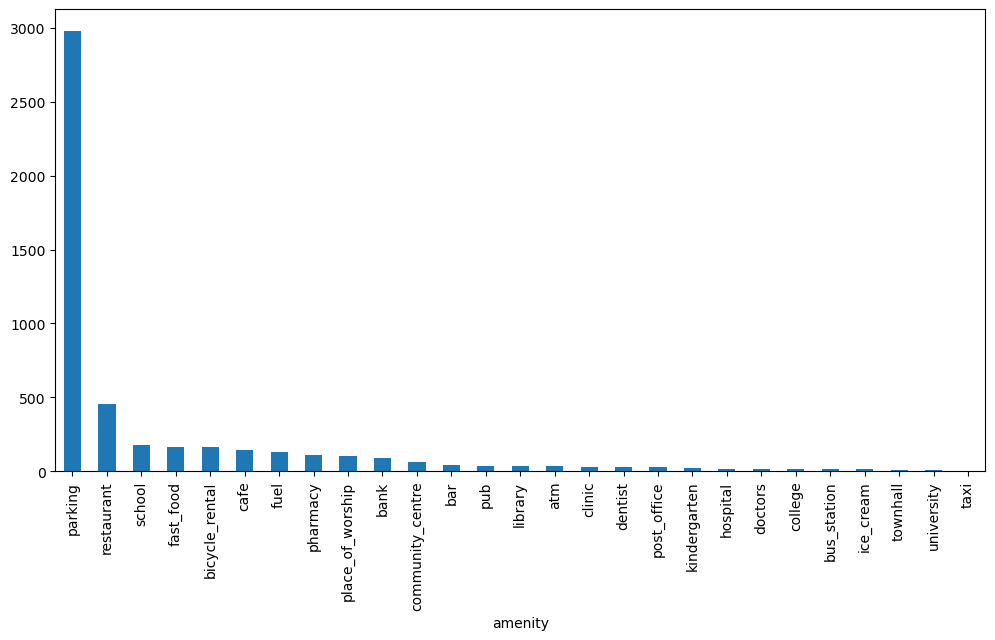

In [ ]:
df_final['amenity'].value_counts().plot(kind='bar', rot=90, figsize=(12, 6))

In [ ]:
df_final.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich